In [15]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import json

from nanoowl.owl_predictor import OwlPredictor
from nanoowl.tree_predictor import (
    TreePredictor, Tree
)
from nanoowl.tree_drawing import draw_tree_output


from nanoowl.tree import Tree
from nanoowl.tree_predictor import TreeOutput

In [2]:
def extract_detections(output_vit: TreeOutput, tree_vit: Tree):

    boxes_xyxy = []
    classes = []
    scores = []

    detections = output_vit.detections
    list_labels = tree_vit.to_dict()['labels'][1:]
    list_labels = [x.replace('a ','').replace('an ','') for x in list_labels]
    output_names = dict(zip(list(range(len(list_labels))), list_labels))

    for detection in detections:

        box = [int(x) for x in detection.box]
        label = detection.labels[0] - 1
        score = detection.scores[0]

        if label >= 0:
            
            boxes_xyxy.append(box)
            classes.append(label)
            scores.append(score)
    
    return output_names, boxes_xyxy, classes, scores

def apply_NMS(boxes, classes, scores, score_threshold=0.0, iou_threshold=0.5):
    unique_classes = set(classes)
    final_boxes, final_classes, final_scores = [], [], []

    for cls in unique_classes:
        # Filtrar cajas, puntuaciones y clases por clase actual
        idxs = [i for i, c in enumerate(classes) if c == cls]
        boxes_cls = [boxes[i] for i in idxs]
        scores_cls = [scores[i] for i in idxs]

        # Convertir a NumPy arrays
        boxes_np = np.array(boxes_cls)
        scores_np = np.array(scores_cls)

        # Aplicar NMS
        nms_indices = cv2.dnn.NMSBoxes(boxes_np, scores_np, score_threshold, iou_threshold)

        if len(nms_indices) == 0:
            continue

        if nms_indices.ndim > 1:
            nms_indices = nms_indices.squeeze()

        # Agregar resultados filtrados a las listas finales
        for i in nms_indices:
            final_boxes.append(boxes_cls[i])
            final_scores.append(scores_cls[i])
            final_classes.append(cls)

    return final_boxes, final_classes, final_scores

def plot_predictions(image_bgr, detection_boxes, detection_classes, detection_confidences, classes_dict):
    output_image = image_bgr.copy()

    # Define an extensive list of colors
    colors = [
        (255, 0, 0), (0, 255, 0), (0, 0, 255), 
        (255, 255, 0), (0, 255, 255), (255, 0, 255), 
        (128, 128, 128), (128, 0, 0), (128, 128, 0), 
        (0, 128, 0), (128, 0, 128), (0, 128, 128), 
        (0, 0, 128), (255, 128, 128), (128, 255, 128), 
        (128, 128, 255), (255, 128, 0), (128, 255, 0), 
        (0, 255, 128), (0, 128, 255), (255, 0, 128), 
        (128, 0, 255), (255, 255, 128), (255, 128, 255), 
        (128, 255, 255), (192, 192, 192), (64, 64, 64), 
        (64, 0, 0), (64, 64, 0), (0, 64, 0)
    ]

    # Calculate the font scale factor based on the image size
    height, width = image_bgr.shape[:2]
    font_scale = max(width, height) / 1000  # Adjust this value as needed

    # Adjust text location offset based on the image size
    x_offset = width // 110  # Horizontal offset
    y_offset = height // 28  # Vertical offset

    for i in range(len(detection_boxes)):
        # Boxes
        xmin, ymin, xmax, ymax = detection_boxes[i]
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)

        # Assign a color based on the class using modulo to avoid errors
        class_id = detection_classes[i]
        color = colors[class_id % len(colors)]

        output_image = cv2.rectangle(output_image, start_point, end_point, color, 2)

        # Classes and scores
        text_location = (xmin + x_offset, ymin + y_offset)  # Adjusted text location
        text = f'{classes_dict[class_id]}-{str(round(detection_confidences[i], 2))}'

        output_image = cv2.putText(output_image, text, text_location, cv2.FONT_HERSHEY_COMPLEX_SMALL, font_scale, color, 1, cv2.LINE_AA)

    return output_image


def inference_owlvit_bgr_image(input_image_bgr, input_prompt: str, model_predictor: OwlPredictor, model_threshold: float, iou_treshold: float):

    input_image_rgb = cv2.cvtColor(input_image_bgr, cv2.COLOR_BGR2RGB)
    input_image_pil = Image.fromarray(input_image_rgb)

    tree = Tree.from_prompt(input_prompt)
    clip_text_encodings = model_predictor.encode_clip_text(tree)
    owl_text_encodings = model_predictor.encode_owl_text(tree)
    
    output_predictor = model_predictor.predict(
            image=input_image_pil, 
            tree=tree,
            clip_text_encodings=clip_text_encodings,
            owl_text_encodings=owl_text_encodings,
            threshold=model_threshold
        )

    label_dict, boxes, classes, scores = extract_detections(output_predictor, tree)
    
    boxes, classes, scores = apply_NMS(boxes, classes, scores, model_threshold, iou_treshold)

    return boxes, classes, scores, label_dict

In [3]:
predictor = TreePredictor(
        owl_predictor=OwlPredictor(
            "google/owlvit-base-patch32",
            image_encoder_engine="../Models/owl_image_encoder_patch32.engine"
    )
)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/23/2023-22:44:25] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


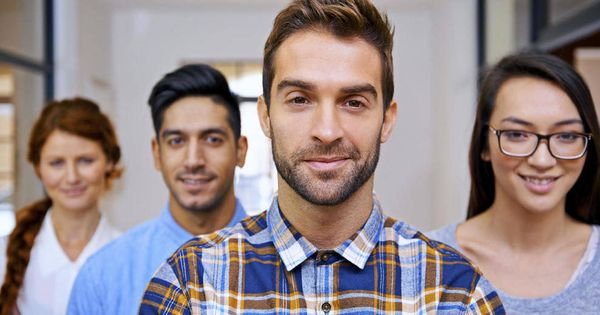

In [4]:
image_bgr = cv2.imread('../Data/people_image.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)
image_pil

/opt/conda/lib/python3.10/site-packages/nanoowl/image_preprocessor.py:71: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  image = torch.from_numpy(np.asarray(image))


[11/23/2023-22:44:27] [TRT] [W] The enqueue() method has been deprecated when used with engines built from a network created with NetworkDefinitionCreationFlag::kEXPLICIT_BATCH flag. Please use enqueueV2() instead.
[11/23/2023-22:44:27] [TRT] [W] Also, the batchSize argument passed into this function has no effect on changing the input shapes. Please use setBindingDimensions() function to change input shapes instead.
[11/23/2023-22:44:27] [TRT] [W] The enqueue() method has been deprecated when used with engines built from a network created with NetworkDefinitionCreationFlag::kEXPLICIT_BATCH flag. Please use enqueueV2() instead.
[11/23/2023-22:44:27] [TRT] [W] Also, the batchSize argument passed into this function has no effect on changing the input shapes. Please use setBindingDimensions() function to change input shapes instead.
[11/23/2023-22:44:27] [TRT] [W] The enqueue() method has been deprecated when used with engines built from a network created with NetworkDefinitionCreationFla

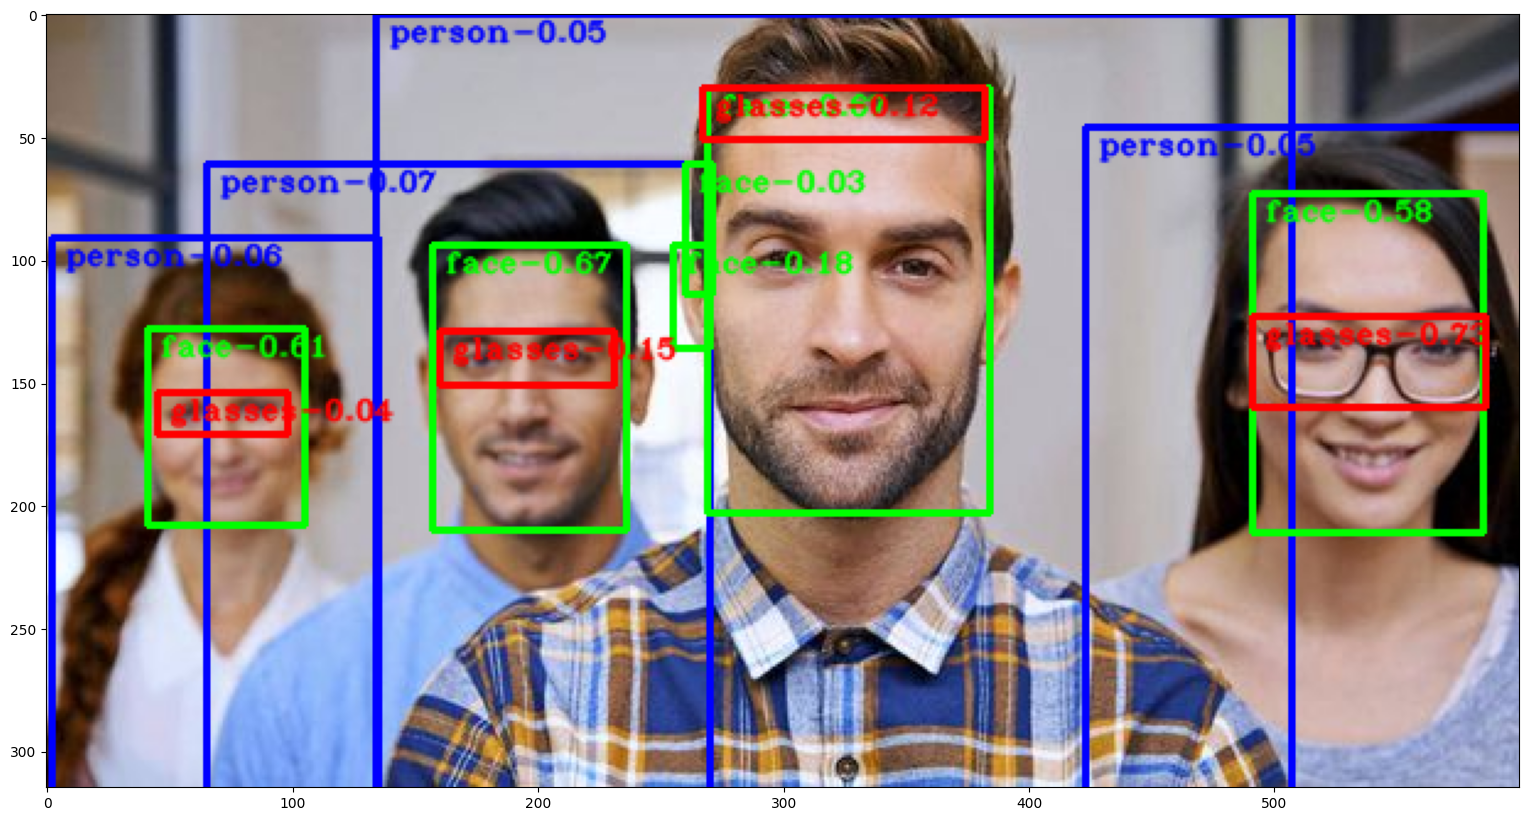

In [5]:
input_prompt = "[a person [a face [a glasses]]]"

threshold_model = 0.03
threshold_iou = 0.5

output_boxes, output_classes, output_scores, output_label_dict = inference_owlvit_bgr_image(image_bgr, input_prompt, predictor, threshold_model, threshold_iou)

output_plot = plot_predictions(image_bgr, output_boxes, output_classes, output_scores, output_label_dict)

fig, ax = plt.subplots()
plt.imshow(cv2.cvtColor(output_plot, cv2.COLOR_BGR2RGB))
fig.set_size_inches(19, 11)

In [18]:
def create_json_labelme_from_image_preds(image_bgr, image_name, output_json_route, boxes, classes, confidence, classes_name):
    
    image_width, image_height = image_bgr.shape[1], image_bgr.shape[0]
    
    labelme_json_data = {
        "version": "5.1.1",
        "flags": {},
        "shapes": [],
        "imagePath": image_name,
        "imageData": None,  # Leave it as None for simplicity
        "imageHeight": image_height,
        "imageWidth": image_width,
    }
    
    num_detections = len(boxes)
    
    for i in range(num_detections):
        
        # Boxes
        xmin, ymin, xmax, ymax = boxes[i]

        start_point = [float(xmin), float(ymin)]
        end_point = [float(xmax), float(ymax)]
        
        class_name = classes_name[classes[i]]

        shape_data = {
            "label": class_name,
            "points": [start_point, end_point],
            "group_id": None,
            "shape_type": "rectangle",
            "flags": {}
        }

        labelme_json_data["shapes"].append(shape_data)
            
    json_file_route = output_json_route + '/' + image_name[:-4] + '.json'
    
    with open(json_file_route, "w") as outfile:
        json_object = json.dumps(labelme_json_data, indent=2)
        outfile.write(json_object)


In [19]:
create_json_labelme_from_image_preds(image_bgr, 'people_image.jpg', '../Data', output_boxes, output_classes, output_scores, output_label_dict)